<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;">
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics | Smart Home Customer Segmentation </h1>
</p>
<p style="color:#1A5276;padding-left:90px;padding-top:0px;position:relative;font-style:italic;font-size:18px">
Application of K-Means and PCA Analysis to detect different customer segments in smart home usage data.</p>

Clustering is a broad toolset for analysis in IoT applications. In general, clustering groups similar objects, such as devices, customers or users, based on the objects' quantitative attributes. In the sample data set for this Notebook, customers will be grouped based on the time they spent interacting with the devices in a Smart Home subscription service. Clustering is both a powerful analysis technique in itself and can be used as a pre-processing step for more complex analysis where the data set is reduced to a single cluster of the original data set to save compute time. 

For many connected products, measuring user or customer engagement is a key reason for collecting IoT data from the device. A connected product manufacturer can cluster users into groups based on usage behavior and use those profiles to understand product feature popularity when designing new products, to target certain users for additional support, or to better understand marketing or services.   

## Set-up: Import Required Notebook Libraries

<p>This Notebook requires a few basic Python libraries including <a href="http://pandas.pydata.org/">`pandas`</a>, <a href="http://www.numpy.org/">`numpy`</a>, <a href="http://scikit-learn.org/">`sklearn`</a> and <a href="https://matplotlib.org/">`matplotlib`</a>.</p>

Basic operations of `numpy` and `pandas` will be used for data transformation, library `matplotlib` will be used for data visualization. The clustering will be done with the KMeans class in sklearn, and the component analysis will be done with the decomposition module also from sklearn.

In [1]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
try:
    import sklearn
except ImportError:
    !conda install -c conda-forge --yes --prefix {sys.prefix} scikit-learn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Background: Problem Description and Approach

Clustering is a very broad and useful profiling technique. Customer segmentation can provide insight into how customers use specific features, into conversion patterns for sales opportunities or into the effects of a campaign or technology upgrade. Device segmentation can tell you which supplier or software upgrade leads to greater overall device lifetime costs or which environments or use cases fatigue devices faster. User segmentation can tell you which types of users use the device most or which users may need better training to configure or use the device most effectively.       

In this Notebook template, we are focused on profiling Smart Home customers who purchased a multi-device Smart Home service. The Smart Home service is focused on homeowner energy savings and consists of a smart thermostat, a smart water heater, a set of smart light bulbs and a set of smart plugs. The service provider wants to understand whether the time a customer spends interacting with the various devices correlates with subscription retention, support calls or upsell/cross-sell success. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> There are many clustering methods suited to different data sets and desired outputs. We are using K-means Clustering here. K-Means is a simple, unsupervised learning algorithm for clustering. K-means does well with large data sets, but has three main drawbacks: 1) you need to input the anticipated number of groups (we'll use a technique to help us guess well); 2) K-means assumes a circular shape to the group, i.e. a uniform distribution around the mean, and this can lead to misassignment of group membership and; 3) the output is deterministic rather than probablistic. K-means does have the distinct advantage that, after clustering is completed, K-clustering can be used to assign new objects into the appropriate cluster. 



<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Data Set Description

A K-means data set has a target or 'key_col' that represents the object to be grouped. In the sample data set, this is the customer, represented by their 'CustomerID'. The attribute of the target around which we are grouping based on similarities is our 'value_col' in the sample data. This is the time (seconds/month) spent interacting with each device. 

Often connected product manufacturers use K-means to profile users based on similarities in feature use. In this case, a user is the target and the duration or frequency of feature use are the attributes. We'll cover more ways to use K-means Clustering in IoT with this template in Step 5, Results Intrepretation. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> This sample data set was collected from multiple devices and their associated mobile apps using AWS IoT and organized into a single AWS IoT Analytics channel. The messages from the devices contain the device ID, a timestamp and report, among other data, various state changes and interactions associated with user interaction. The author of the data set used the Activities in the AWS IoT Analytics pipelines to filter the incoming messages to messages that contain user interactions of interest, like configuration changes or viewing of device output. The Lambda enrichment activity was used to look-up the customer ID in a 3rd party CRM given the device ID, and a series of data store queries was used to organize the data set by customer and calculate and sum the duration spent in user interactions of interest across the customers devices.   

In [3]:
# describe the dataset structure (In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission)
dataset = "all_data"
key_col = 'CustomerID'    # name of key column
value_col = ['TimeIn1','TimeIn2','TimeIn3','TimeIn4'] # list of value columns

Before loading the data we need to initialize the client for accessing IoT Analytics datasets:

In [4]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

Then we retrieve the dataset content S3 location and load it into a DataFrame object:

In [5]:
try:  # read dataset contents into a data frame
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
    df = pd.read_csv(dataset_url)
    
    if df.empty:
        raise Exception('No data found')
except: # use sample dataset in case of any error
    key_col = 'CustomerID'
    value_col = ['TimeIn1','TimeIn2','TimeIn3','TimeIn4'] 
    
    df = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/channel.csv')
    
    from IPython.display import display, Markdown
    import traceback
    display(Markdown('# <span style="color:black">{}</span>\n{}'.format(
        'Failed to load data. Using the example data set instead.', traceback.format_exc())))

all_col = [key_col] + value_col
mainData_df = df[all_col]

# <span style="color:black">Failed to load data. Using the example data set instead.</span>
Traceback (most recent call last):
  File "<ipython-input-5-59ace4397771>", line 2, in <module>
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 314, in _api_call
    return self._make_api_call(operation_name, kwargs)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/botocore/client.py", line 612, in _make_api_call
    raise error_class(parsed_response, operation_name)
botocore.errorfactory.InvalidRequestException: An error occurred (InvalidRequestException) when calling the GetDatasetContent operation: 1 validation error detected: Value 'all_data' at 'datasetName' failed to satisfy constraint: Member must satisfy regular expression pattern: ^[a-zA-Z0-9_]+$


In [6]:
# display first 10 entries in the DataFrame 
mainData_df.head(10)

,CustomerID,TimeIn1,TimeIn2,TimeIn3,TimeIn4
0,c0004936086,336.93,592.82,3760.63,214.56
1,c0070362859,395.58,627.17,1198.91,333.56
2,c0017106439,410.58,877.55,1082.64,670.11
3,c0014388169,992.31,522.22,895.21,198.17
4,c0006020255,425.68,459.44,908.93,209.15
5,c0094305615,446.00,809.63,3549.63,355.70
6,c0086662028,270.71,656.74,1935.00,172.52
7,c0081213964,420.60,809.06,3797.99,651.28
8,c0092316682,305.55,299.02,4531.72,473.67
9,c0063065819,355.82,428.52,4678.50,295.72


In [7]:
# retrieve index of last data column, range [1:lastDataColumnIndex] for use in determining the number of clusters
lastDataColumnIndex = len(mainData_df.columns)

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Processing Data</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Identify Correct Number of Clusters

As mentioned in BACKGROUND, K-means clustering requires that we input the number of anticipated clusters or groups for the data set. This is often information that we do not have, so we must first inspect the data set to see how many groups we have. To do this we need to know a little more about how k-means works. K-means calculates a center point for each potential cluster, eventually finding a local maximum of similarity (or a minimum of difference) between the surrounding data points. Each point is then compared to each center and associated with the cluster with which it is most similar. To tell how well the clusters fit around these center points we measure the average squared distance from the centerpoint. Mathematically, this is referred to as the 'intertia' of the cluster. A cluster with a large intertia is very spread out.   

To identify how many clusters we have in our data, we will fit k-means for many different numbers of clusters or k values. We'll then compute the interia or how spread out the cluster members are from the center.

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> If we guess too few clusters, the clusters k-means defines will be spotty and have clear sub-groups which are not defined. If we guess too many clusters, k-means will attempt to segment a single cluster into seperate clusters and may attempt to co-opt members from near-by clusters.  

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> our sample data values are all in units of seconds/month. If your data set contains values with multiple units of measurement, for example gallons of water and average wattage used, you would need to normalize your data to remove the differences in scale between the various units of measure. Examples of using the MinMaxScaler transformation can be found in other Notebooks or <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">CLICK</a> to learn more.

In [8]:
# create list to hold our different classifier with different k values
km_list = []

# create list of k values we want to try
k_list = range(2, 11)

# for each k fit a k-means classifier
for k in k_list:
    km = KMeans(n_clusters = k)
    km.fit(mainData_df.iloc[:,1:lastDataColumnIndex])
    km_list.append(km)

# the interia_ attribute of the kmeans classifiers contains the within cluster sum of squared distances, 
interia_list = [x.inertia_ for x in km_list]

We'll now plot the interia for each k or number of guessed clusters. Once plotted, we'll be able to see a transition from k values that are too low to k-values that offer diminishing returns, which suggests the data is then overfit. 

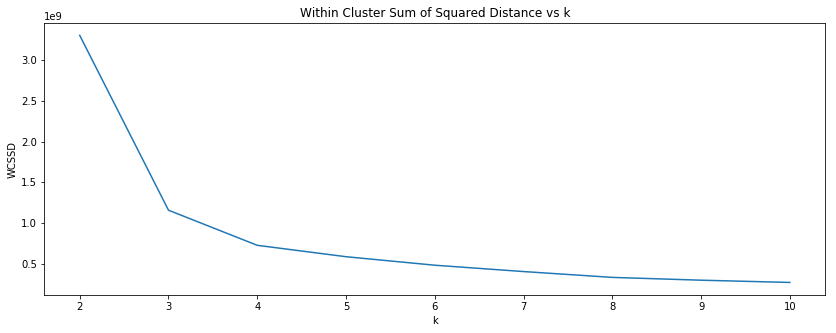

In [9]:
# Plot within cluster sum of squared distances (inertia) for different k values

# create the plt figture
plt.figure(figsize=(14, 5))

# set the title, and label of x axis and y axis - then plot
plt.title("Within Cluster Sum of Squared Distance vs k")
plt.ylabel("WCSSD")
plt.xlabel("k")

plt.plot(k_list, interia_list)

To select the best guess for the number of clusters, k, in order to run the K-mean algorithm, we need to identify the 'k' value at the inflection point (or elbow) in the above plotted curve. If no clear inflection point is present, it may mean that there isn't a clear separation or differentiation of groups in your data. You may want to consider revisiting your data set and see if there are additional attributes you have eliminated from consideration that might help tease out group definitions. See Profiling with Clusters in the DOING MORE WITH RESULTS to learn how you can add attributes back into profiling after clusters have been identified. 
 

For our Smart Home sample data set, we most likely have 3 or 4 clusters in our data. Next we'll set the cluster number to 3.

In [10]:
clusterNumber = 3

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Running K-means Algorithm</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

K-Means clustering is an excellent example of the power of algorithm packages like scikit-learn. Running the algorithm against our data set is a single line .fit_predict function call. With the correct number of clusters, k, the k-means function will calculate the cluster centers (minimum diference points) and then assign customers to each cluster.


In [11]:
km = KMeans(n_clusters = clusterNumber)

# Feed the data in and compute the cluster
cluster = km.fit_predict(mainData_df.iloc[:,1:lastDataColumnIndex])

# Adding the cluster result back to customerData_df dataframe and printing the first 10 rows of the dataframe
mainData_df["Cluster"] = cluster
mainData_df.head(10)

,CustomerID,TimeIn1,TimeIn2,TimeIn3,TimeIn4,Cluster
0,c0004936086,336.93,592.82,3760.63,214.56,1
1,c0070362859,395.58,627.17,1198.91,333.56,0
2,c0017106439,410.58,877.55,1082.64,670.11,0
3,c0014388169,992.31,522.22,895.21,198.17,0
4,c0006020255,425.68,459.44,908.93,209.15,0
5,c0094305615,446.00,809.63,3549.63,355.70,1
6,c0086662028,270.71,656.74,1935.00,172.52,0
7,c0081213964,420.60,809.06,3797.99,651.28,1
8,c0092316682,305.55,299.02,4531.72,473.67,1
9,c0063065819,355.82,428.52,4678.50,295.72,1


The Cluster column above displays the index, 0 to N-1, for each of N Clusters. In the results for our Smart Home sample data set, only 2 (index 0 and index 1) of the 3 clusters appear within the first 10 customers. 

In our sample data set, a cursory glance at these first 9 customers will give you some basic information about the clusters, such as common cluster names and what kinds of customers are grouped into these clusters.


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4  |  Evaluating Results through Visualization</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Now that we have our population of objects (customers) segmented into groups, we can inspect and visualize what those groups look like in order to evaluate how well our clustering worked and begin to draw conclusions about the insights the grouping shows us. We'll start by simply looking at the number of members in each group, i.e. the count of objects in each cluster. With our sample data, this count tells us how many customers fall into any particular group and if one group is numerically dominant.

### Simple Group Member Count

To perform the membership count we'll use the groupby function of Pandas DataFrame to collect each customer into the assigned cluster. We then create a new DataFrame that contains only the Cluster index and member count for the associated cluster.

In [12]:
# group the recrods base on the 'Cluster' column of the data
clusterGroup = mainData_df.groupby(mainData_df['Cluster'])

# count the elements number of each cluster, and store the result in new DataFrame clusterCount_df
clusterCount_df = clusterGroup.count().reset_index().iloc[:, 0:2]
clusterCount_df.columns = ['Cluster', 'Count']

# sort the clusterCount_df and give each of the cluster a name base on the sorting result.
# so that we can refer to the clusters by name while we are discussing the attribute of the clusters 
clusterCount_df = clusterCount_df.sort_values(by ='Count', ascending=False)
clusterCount_df = clusterCount_df.reindex() 
clusterCount_df['ClusterNumber'] =  range(0, len(clusterCount_df))
clusterCount_df['ClusterName'] = clusterCount_df.apply(lambda x: 'Cluster'+str(x[2]), axis=1)
clusterCount_df = clusterCount_df.drop('ClusterNumber', axis=1)
clusterCount_df = clusterCount_df.sort_values(by ='Cluster')

# Get the cluster name list sorted by cluster id
# So that we can get the cluster name based on cluster id in other cells
clusterNameList = []
for clusterName in clusterCount_df.loc[:,"ClusterName"]:
    clusterNameList.append(clusterName)
    
# add the ClusterName column in mainData_df dataframe.
# So that end users can get the mapping relationship in main data frame
mainData_df['ClusterName'] = mainData_df.apply(lambda x: clusterNameList[x[5]], axis=1)

# display the cluster counting result
clusterCount_df

,Cluster,Count,ClusterName
0,0,473,Cluster1
1,1,474,Cluster0
2,2,53,Cluster2


Our Smart Home device usage groups show two dominant customer usage profiles and a much smaller one. Although the results for our sample data set are pretty clear, we'll plot them for completeness. 

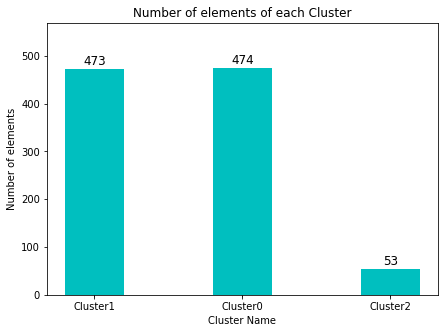

In [13]:
# create plt figure to display bar chart of each cluster
plt.figure(figsize=(7,5))

# x axis is the cluster name, y axis is the element number of the cluster 
x = clusterCount_df['Cluster']
y = clusterCount_df['Count']

barNameList = [" "]+clusterNameList
    
plt.xticks(range(0,len(clusterCount_df)),barNameList) 

# display the bar chart
plt.bar(x, y, width=0.4, align='center', color = 'c')

# set the title and labels
plt.xlabel('Cluster Name')
plt.ylabel('Number of elements')
plt.title('Number of elements of each Cluster')

# set the length of y axis to 1.2 times of largest number of elements
# so that we have enough space to display the element number
plt.ylim(0,np.max(clusterCount_df["Count"]) * 1.2)

# set the major and minor locator of x axis, so that each cluster has it's cluster name under the bar
ax=plt.gca() 
xLocator = ticker.MultipleLocator(1)
ax.xaxis.set_major_locator(xLocator)
ax.xaxis.set_minor_locator(xLocator)

# display the number of element on each of the bar
for a,b in zip(x,y):
    plt.text(a, b+3, '%.0f' % b, ha='center', va= 'bottom',fontsize=12)

### Principal Component Analysis [PCA] and t-Distributed Stochastic Neighbor Embedding [t-SNE]

In our sample data set, we had four Smart Home devices that each customer had purchased as part of the Smart Home Subscription. To plot the profiles of usage across all of these devices within each cluster, we need to collapse the 4 dimensional data set to 2 dimensions to view the cluster variability. <a href="http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">PCA</a> is a common transformation technique to convert high dimensional data into 2 dimensions highlighting variation.  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">t-SNE</a> in contrast to PCA, emphasizes the similarity in the target data set.  

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> PCA is used to reduce dimensions, emphasize variation and bring out strong patterns in a data set. Our sample data is only 4D but if we had higher dimensions, 50D+, we'd need to use PCA to reduce the data set dimensions before we could apply t-SNE.  

Let us try them both out and see how it looks below. We'll start by preparing a DataFrame with our original data set and the Cluster index for each object (customer). We'll then calculate PCA and t-SNE fitting parameters and add them to our DataFrame.

In [14]:
# initialize and fit PCA transform
pca = PCA(n_components=2)
pcaOutput = pca.fit_transform(mainData_df.iloc[:,1:lastDataColumnIndex])

# initialize and fit t-SNE transform, set random seed for reproducibility
np.random.seed(107)
tsne = TSNE(n_components=2)
tsneOutput = tsne.fit_transform(mainData_df.iloc[:,1:lastDataColumnIndex])

# assign PCA and t-SNE parameter outputs to our DataFrame
mainData_df["tsne_x"] = tsneOutput[:,0]
mainData_df["tsne_y"] = tsneOutput[:,1]

mainData_df["pca_x"] = pcaOutput[:,0]
mainData_df["pca_y"] = pcaOutput[:,1]

# display the full DataFrame
mainData_df.head(10)

,CustomerID,TimeIn1,TimeIn2,TimeIn3,TimeIn4,Cluster,ClusterName,tsne_x,tsne_y,pca_x,pca_y
0,c0004936086,336.93,592.82,3760.63,214.56,1,Cluster0,30.211973,13.143618,427.106268,-44.145312
1,c0070362859,395.58,627.17,1198.91,333.56,0,Cluster1,-6.817552,-19.691345,-2129.356105,-47.679962
2,c0017106439,410.58,877.55,1082.64,670.11,0,Cluster1,-7.560820,-15.257977,-2237.824776,185.805115
3,c0014388169,992.31,522.22,895.21,198.17,0,Cluster1,1.275540,-44.050961,-2433.056388,-114.683044
4,c0006020255,425.68,459.44,908.93,209.15,0,Cluster1,-12.464899,-31.781796,-2420.881659,-211.469856
5,c0094305615,446.00,809.63,3549.63,355.70,1,Cluster0,25.133741,5.491431,218.533268,169.126520
6,c0086662028,270.71,656.74,1935.00,172.52,0,Cluster1,33.252922,-16.638487,-1399.892985,-7.983416
7,c0081213964,420.60,809.06,3797.99,651.28,1,Cluster0,14.033010,6.177396,476.172536,156.962868
8,c0092316682,305.55,299.02,4531.72,473.67,1,Cluster0,20.821260,27.294273,1209.707434,-340.050023
9,c0063065819,355.82,428.52,4678.50,295.72,1,Cluster0,16.607409,27.575289,1349.229134,-197.713743


PCA has the distinct advantage that it allows us to retrieve the cluster centers of each cluster and transform the centers into 2 dimension space with the pca.transform function. This way we can display the center point of each cluster on the same plot as the members of the cluster.

In [15]:
# km.cluster_centers_ are the center points of each cluster.
# call pca.transform() to project the center points into 2 dimension space
componentGroup_df = pd.DataFrame(pca.transform(km.cluster_centers_))

# set the column name of the DataFrame
componentGroup_df.columns = ["center_x", "center_y"]

componentGroup_df

,center_x,center_y
0,-2187.732314,25.610684
1,1276.650907,-30.082568
2,8106.884044,40.477050


### Plot Transformed Clusters

Now we have information about which cluster each customer belongs to, and the two main components of customer behavior data. Each technique uses color to code the members of each group, but uses different mathematical transforms to represent how each member is plotted in 2 dimensions. We can visualize the clustering result by displaying customer records in two dimension space, with color decided by their clustering result, using main components data as the x and y axis.

At the sametime, we have computed the coordinate of center points of each cluster, we can display it in the same figure.

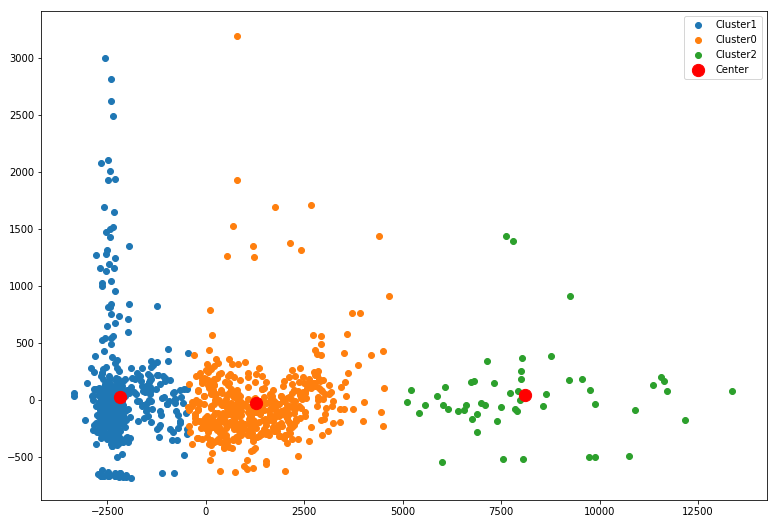

In [16]:
# Create the plot figure for PCA
plt.figure(figsize=(13,9))

# display all the transformed samples in the 2 dimension space with different color

for clusterName in clusterCount_df.loc[:,"Cluster"]:
    plt.scatter(mainData_df.loc[(mainData_df['Cluster']==clusterName)]["pca_x"], mainData_df.loc[(mainData_df['Cluster']==clusterName)]["pca_y"])

# display the center points with red color on the same plot
labelList = clusterNameList + ["Center"]
plt.scatter(componentGroup_df.loc[:,"center_x"], componentGroup_df.loc[:,"center_y"], c="red", s=150, marker='o')


plt.legend(labelList, loc='upper right', fontsize=10)


For our Smart Home sample data set, we can see that Cluster 0 and Cluster 1 are both tightly bound groups with Cluster 1 exhibiting a significant vertical variance mode. The vertical variance mode may suggest a sub-group within Cluster 1. Cluster 2 on the other hand, has a broad distribution of members. In user patterns for device collections, it is often the case that 'super users' have a broader pattern of usage with the unifying feature that they spend more time on each device than any other group or cluster. 

Another common technique to make 2 dimensional representations of higher dimensional data is t-SNE, the same data plotted using t-SNE is shown below

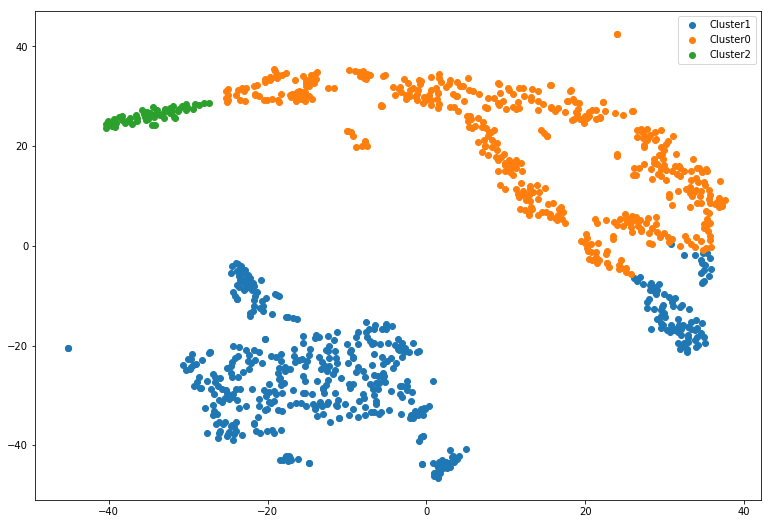

In [17]:
# Create plt figure
plt.figure(figsize=(13,9))

# display TSNE 

for clusterName in clusterCount_df.loc[:,"Cluster"]:
    plt.scatter(mainData_df.loc[(mainData_df['Cluster']==clusterName)]["tsne_x"], mainData_df.loc[(mainData_df['Cluster']==clusterName)]["tsne_y"])
    
plt.legend(clusterNameList, loc='upper right', fontsize=10)

As we discussed earlier, t-SNE focuses on highlighting similarity in a data set. With our sample Smart Home data set, the t-SNE results shown in the plot suggest that our k-means may have incorrectly grouped some members in Cluster 1 that should be in Cluster 0.

In both the PCA and t-SNE transformations, we noticed that there are some 'super users' in our data, who have a broad pattern of device usage with a variable amount of time spent on each device. PCA represents them with a vertical line plotted on cluster 1 whereas t-SNE clearly bundles them a complete different cluster. 

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">HUMAN LEARNING NOTE</b> If you notice a different cluster distribution in the transformations, you can revisit your assumptions on k-value or cluster numbers and test again.


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 5  |  Interpreting Results</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>



For our customer segmentation task, K-Means is a good starting point. With K-Means, you can divide customer records into different clusters without any label data.

And, with PCA or t-SNE and visualizing tools, you can display high dimension data into two dimension space and check the clustering result.


PCA shows that usage patterns in Cluster 1 are quite similar and thus these customers could be marketed to with the same techniques. Cluster 2 is, however, less cohsive and may require a personalization strategy.


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 6  |  Doing More With Results</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>


After the more difficult data manipulation, we turn to how to leverage k-means segementation to drive meaningful business results. Obviously, this depends on your use case, but there are several easy ways to derive more value from these groupings. Below we'll briefly describe Profiling, Cluster Assignment and Cluster Evolution. 

### Analyzing time spending behavior of each cluster

Caculate the average time of each cluster

In [18]:
# calling groupby mean function to cacuate average time spending.
profile_df = mainData_df.groupby(['ClusterName'])[value_col].mean()
profile_df = profile_df.reset_index()

profile_df

,ClusterName,TimeIn1,TimeIn2,TimeIn3,TimeIn4
0,Cluster0,438.462004,600.611688,4602.173713,466.471983
1,Cluster1,462.206744,692.937125,1144.195243,235.434503
2,Cluster2,542.102075,562.830755,11440.129434,327.326792


Display average time spending data

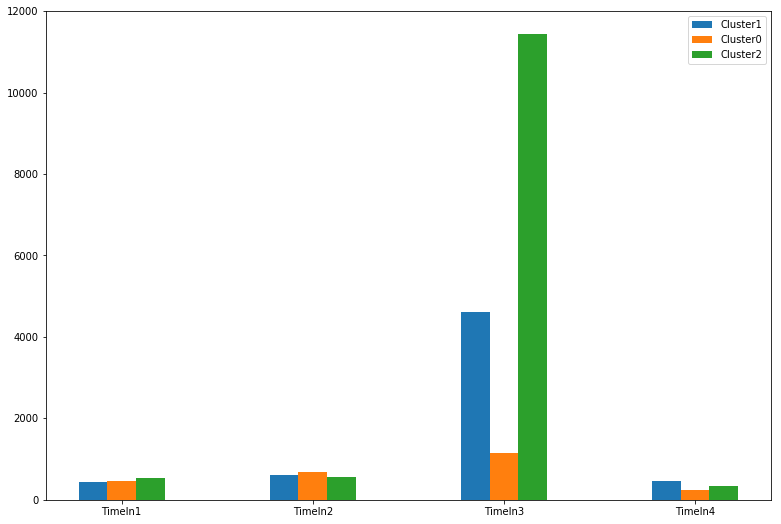

In [19]:

# Create plt figure
plt.figure(figsize=(13,9))

ind = np.arange(len(value_col))                # the x locations for the groups
width = 0.15

# for col in np.arange(len(value_col)):
# for row in np.arange(len(clusterCount_df)):
#     plt.bar(ind+row*width, profile_df[row:row+1][value_col], width)

for row in np.arange(len(clusterCount_df)):
    plt.bar(ind+row*width, profile_df[value_col].iloc[[row]].values[0], width)


plt.xticks(np.arange(len(value_col)) + width, value_col)

plt.legend(clusterNameList, loc='upper right', fontsize=10)

In this data set, the main difference between clusters is the time each cluster spend in "TimeIn3".

### Profiling with in Clusters

Once we have well-defined groups, we can inspect the characteristics of the members beyond the attributes present in the data set used for clustering. Similarities in the metadata of each group can further add context to the business decisions driven by the identification of our groups. 

For instance, our Smart Home customers' purchasing history, home location or demographic may correlate with the grouping of device usage. If more Cluster 1 homes have teenagers in the home, that may indicate that the presence of teenagers increases the use of the security camera. A focus group could tease out whether this is an opportunity to increase sales by marketing to a secondary feature set around parental control.

### Assigning New Members to Existing Clusters

In addition to profiling the members within a group, K-means clustering can be used to assign new objects to the appropriate group. If you were to run another K-means clustering with the new data, the new members would be used to adjust the group 'centroids' or the center points which in turn could change the group definitions and membership of existing objects. If your goal is to use your k-means groups to classify which of the existing groups a new object best fits into, you have two options, comparison to the sum of squared distances, or machine learning. 

<b>Sum of Squared Distances:</b> The quickest way to assign a new object to an existing group is to calculate the distance of the new object from each of the group centroids and assign to the group with the shortest distance between the new object and the group's centroid. Use <a href="https://en.wikipedia.org/wiki/Total_sum_of_squares">Total Sum of Squares</a> (TSS) to calculate the distances.

<b>Build a Classifier with Supervised ML:</b> Now that you've partitioned your devices/components/users/customers into groups with k-means, you can use these groups to train a classification model with a <a href="http://scikit-learn.org/stable/modules/svm.html">Support Vector Machine</a> (SVM). Once your classifier is trained, you can easily run large numbers of new objects through it to be classified into the groups you just created. Keep in mind that for SVM to be successful, you'll need well formed groups or clusters. 

### Trend Analysis - Monitoring Cluster Evolution

Clustering within a time series or time period gives you a snapshot of group membership and profiling. Often Group membership and behavior evolves over time, particularly in IoT where devices age and many users and customers are new to the technology. A more in-depth analysis looks at clustering over set intervals to identify how individual members may move between groups or how the group size or profile may be changing over time. The SVM classifier mentioned in the previous section can also be used to look at the group population level changes over time without changing the definition of the group.

Example Clustering Trends
<ul style="margin-left:50px">
<li><i>Group Membership:</i> Do members move between groups in a regular pattern?</li>
<li><i>Group Seasonality:</i> Do groups swell or shrink in membership in cyclical patterns?</li>
<li><i>Group Profile:</i> Has the characteristic metadata about any group changed over time?</li>
</ul>

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> You can use an AWS IoT Analytics scheduled query to create data sets for regular clustering analysis and classification.
      

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>